<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Statsmodels.api" data-toc-modified-id="Statsmodels.api-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Statsmodels.api</a></span></li><li><span><a href="#PyMC" data-toc-modified-id="PyMC-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PyMC</a></span><ul class="toc-item"><li><span><a href="#Approach-1:-Base-PyMC,-Gaussian-Random-Walk" data-toc-modified-id="Approach-1:-Base-PyMC,-Gaussian-Random-Walk-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Approach 1: Base PyMC, Gaussian Random Walk</a></span></li><li><span><a href="#PyMC-StateSpace-Implementation" data-toc-modified-id="PyMC-StateSpace-Implementation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>PyMC StateSpace Implementation</a></span><ul class="toc-item"><li><span><a href="#Model" data-toc-modified-id="Model-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Priors" data-toc-modified-id="Priors-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Priors</a></span><ul class="toc-item"><li><span><a href="#Unconditional-Prior" data-toc-modified-id="Unconditional-Prior-3.2.2.1"><span class="toc-item-num">3.2.2.1&nbsp;&nbsp;</span>Unconditional Prior</a></span></li><li><span><a href="#Conditional-Prior" data-toc-modified-id="Conditional-Prior-3.2.2.2"><span class="toc-item-num">3.2.2.2&nbsp;&nbsp;</span>Conditional Prior</a></span></li></ul></li><li><span><a href="#Posterior" data-toc-modified-id="Posterior-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Posterior</a></span><ul class="toc-item"><li><span><a href="#Conditional-Posterior" data-toc-modified-id="Conditional-Posterior-3.2.3.1"><span class="toc-item-num">3.2.3.1&nbsp;&nbsp;</span>Conditional Posterior</a></span></li><li><span><a href="#Unconditional-Posterior" data-toc-modified-id="Unconditional-Posterior-3.2.3.2"><span class="toc-item-num">3.2.3.2&nbsp;&nbsp;</span>Unconditional Posterior</a></span></li></ul></li></ul></li><li><span><a href="#Outputs-Compared" data-toc-modified-id="Outputs-Compared-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Outputs Compared</a></span></li><li><span><a href="#Smoother-Outputs-from-all-3-models" data-toc-modified-id="Smoother-Outputs-from-all-3-models-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Smoother Outputs from all 3 models</a></span></li></ul></li></ul></div>

In [1]:
%matplotlib inline
import sys

sys.path.append("..")

import jax

jax.config.update("jax_platform_name", "cpu")

import numpyro

numpyro.set_host_device_count(4)

import pymc as pm
import pytensor
from pytensor import tensor as pt

import arviz as az
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats, linalg

import time

config = {
    "figure.figsize": (12, 4),
    "figure.dpi": 72.0 * 2,
    "figure.facecolor": "w",
    "axes.grid": True,
    "grid.linewidth": 0.5,
    "grid.linestyle": "--",
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
}

plt.rcParams.update(config)

# Data

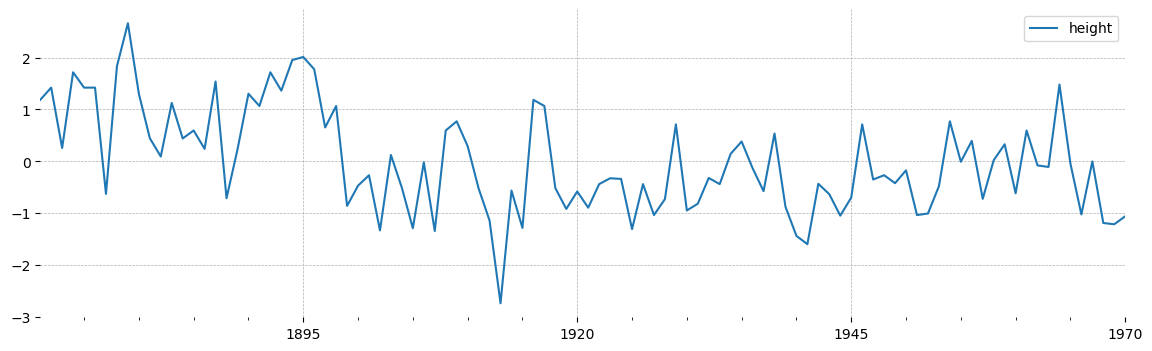

In [2]:
nile = pd.read_csv("../pymc_experimental/tests/statespace/test_data/nile.csv")
nile.index = pd.date_range(start="1871-01-01", end="1970-01-01", freq="AS-Jan")
nile.rename(columns={"x": "height"}, inplace=True)

nile = (nile - nile.mean()) / nile.std()
fig, ax = plt.subplots(figsize=(14, 4), dpi=100)
nile.plot(ax=ax)
plt.show()

# Statsmodels.api 

In [3]:
nile_ml = sm.tsa.UnobservedComponents(nile, level="lltrend", initialization="approximate_diffuse")
res = nile_ml.fit(disp=0)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                 height   No. Observations:                  100
Model:             local linear trend   Log Likelihood                -127.011
Date:                Sat, 22 Jul 2023   AIC                            260.022
Time:                        05:40:16   BIC                            267.777
Sample:                    01-01-1871   HQIC                           263.159
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.5125      0.096      5.333      0.000       0.324       0.701
sigma2.level         0.0612      0.042      1.445      0.148      -0.022       0.144
sigma2.trend      1.251e-11      0.000   8.51e-08      1.000      -0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.30   Prob(JB):                         0.98
Heteroskedasticity (H):               0.62   Skew:                             0.05
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [4]:
ml_point_estimates = res.params.values

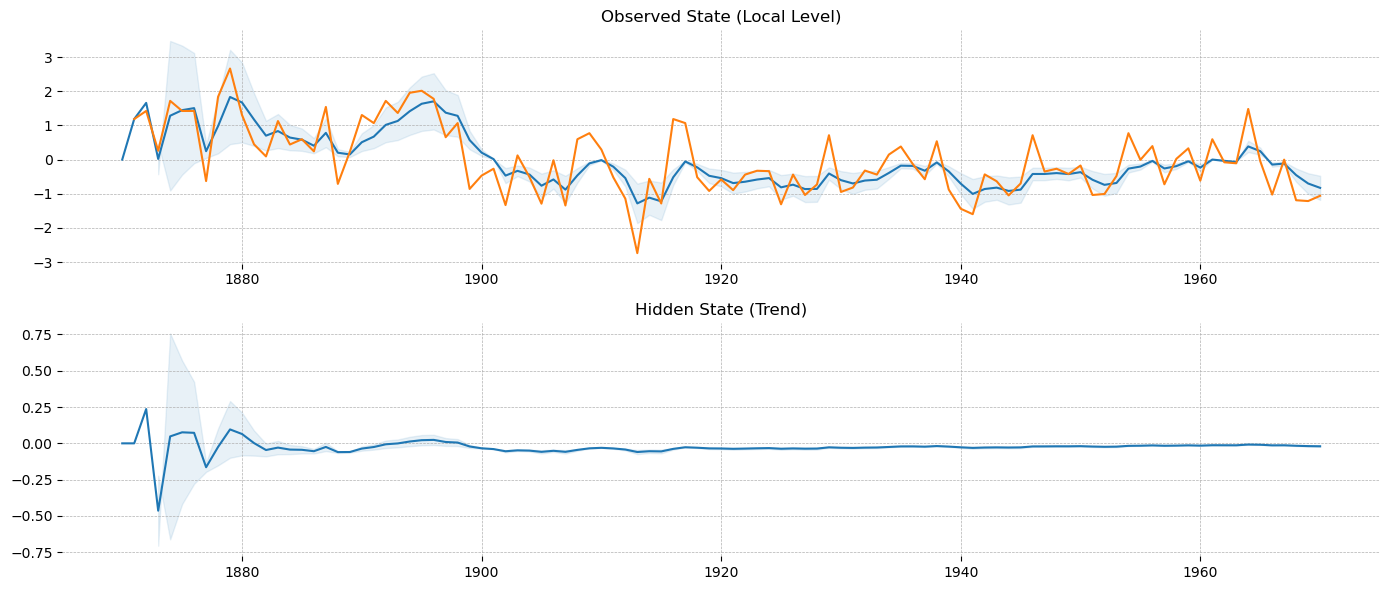

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=100)
x_values = nile.index
x_values_plus = pd.date_range(start="1870-01-01", end="1970-01-01", freq="AS-Jan")

state_mean = res.states.predicted.values
state_cov = res.states.predicted_cov.values.reshape(101, 2, 2)
ci_bounds = 1.96 * np.einsum("tk,tkj->tj", state_mean, state_cov)

upper = state_mean + ci_bounds
lower = state_mean - ci_bounds


ax[0].plot(x_values_plus, state_mean[:, 0])
ax[0].fill_between(x_values[2:], y1=lower[3:, 0], y2=upper[3:, 0], color="tab:blue", alpha=0.1)

ax[0].plot(x_values, nile.values)
ax[0].set(title="Observed State (Local Level)")

ax[1].plot(x_values_plus, state_mean[:, 1])
ax[1].fill_between(x_values[2:], y1=lower[3:, 1], y2=upper[3:, 1], color="tab:blue", alpha=0.1)

ax[1].set(title="Hidden State (Trend)")

fig.tight_layout()
plt.show()

# PyMC StateSpace

In [6]:
import pymc_experimental.statespace as pmss

state_space_model = pmss.BayesianLocalLevel(verbose=True)

Model successfully initialized! The following parameters should be assigned priors inside a PyMC model block: 
	x0 -- shape: (2,), constraints: None, dims: ('states',)
	P0 -- shape: (2, 2), constraints: Positive Semi-definite, dims: ('states', 'states_aux')
	sigma_obs -- shape: (1,), constraints: Positive, dims: ('observed_states',)
	sigma_state -- shape: (2,), constraints: Positive, dims: ('states',)


In [7]:
state_space_model.coords

{'states': ['level', 'trend'],
 'states_aux': ['level', 'trend'],
 'observed_states': ['level'],
 'observed_states_aux': ['level'],
 'shocks': ['level', 'trend']}

### Model

In [8]:
with pm.Model(coords=state_space_model.coords) as nile_model:
    state_space_model.add_default_priors()

In [9]:
nile_model

In [10]:
with nile_model:
    state_space_model.build_statespace_graph(data=nile, mode="JAX")

In [11]:
nile_model

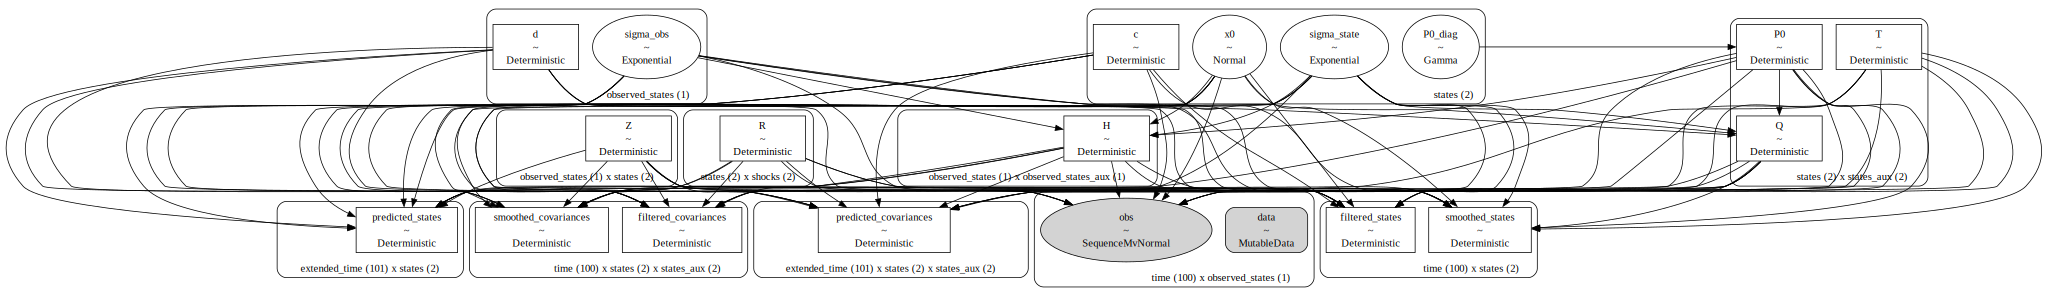

In [14]:
pm.model_to_graphviz(nile_model)

### Prior Predictive Sampling

Like in the case of GPs, we can consider both an unconditional and a conditional output distribution. Helper functions in the PyMC Statespace `model` class help the user sample and plot one or the other.

#### Unconditional Prior

In [12]:
# with nile_model:
#     prior_simulated_states, _ = state_space_model.sample_unconditional_prior(
#         n_steps=100, n_simulations=10, prior_samples=500
#     )

In [13]:
# fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
# for idx, (axis, name) in enumerate(
#     zip(fig.axes, ["Observed State (Level)", "Hidden State (Trend)"])
# ):
#     axis.plot(prior_simulated_states[:, :, idx].T)
#     axis.set(title=name)

# fig.set_facecolor("w")
# fig.tight_layout()
# plt.show()

#### Conditional Prior

The fit looks better than it is because the wide confidence intervals crush the means together. Up to +/- 4 standard deviations of variance of the trend is crazy 

In [14]:
# with nile_model:
#     conditional_prior = state_space_model.sample_conditional_prior(
#         n_simulations=10, filter_output="filtered"
#     )

# fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
# for idx, (axis, name) in enumerate(
#     zip(fig.axes, ["Observed State (Level)", "Hidden State (Trend)"])
# ):
#     axis.plot(conditional_prior[:, :, idx].T, color="0.5", alpha=0.1)
#     axis.plot(
#         conditional_prior[:, :, idx].mean(axis=0),
#         color="tab:orange",
#         label="Prior Filtered Mean",
#     )
#     if idx == 0:
#         axis.plot(nile.values, color="tab:red", label="Observed Data")
#     axis.set(title=name)

# ax[0].legend(loc="lower left")
# fig.set_facecolor("w")
# fig.tight_layout()
# plt.show()

## Sampling

In [15]:
with nile_model:
    idata = pm.sample(nuts_sampler="numpyro")

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:04.619669
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:16.143311
Transforming variables...
Transformation time =  0:00:05.237810


### Posterior

In [16]:
az.summary(idata, var_names=state_space_model.param_names)

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0[level],0.434,0.797,-1.130,1.854,0.014,0.011,3582.0,2565.0,1.0
x0[trend],-0.008,0.762,-1.437,1.428,0.012,0.013,4146.0,2558.0,1.0
"P0[level, level]",1.876,1.326,0.035,4.170,0.020,0.015,3341.0,1915.0,1.0
"P0[level, trend]",0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
"P0[trend, level]",0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
"P0[trend, trend]",1.728,1.265,0.054,3.904,0.019,0.014,3603.0,2056.0,1.0
sigma_obs[level],0.478,0.107,0.275,0.671,0.002,0.001,3200.0,2859.0,1.0
sigma_state[level],0.131,0.088,0.005,0.292,0.002,0.001,2672.0,2046.0,1.0
sigma_state[trend],0.001,0.002,0.000,0.005,0.000,0.000,4612.0,2277.0,1.0


/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


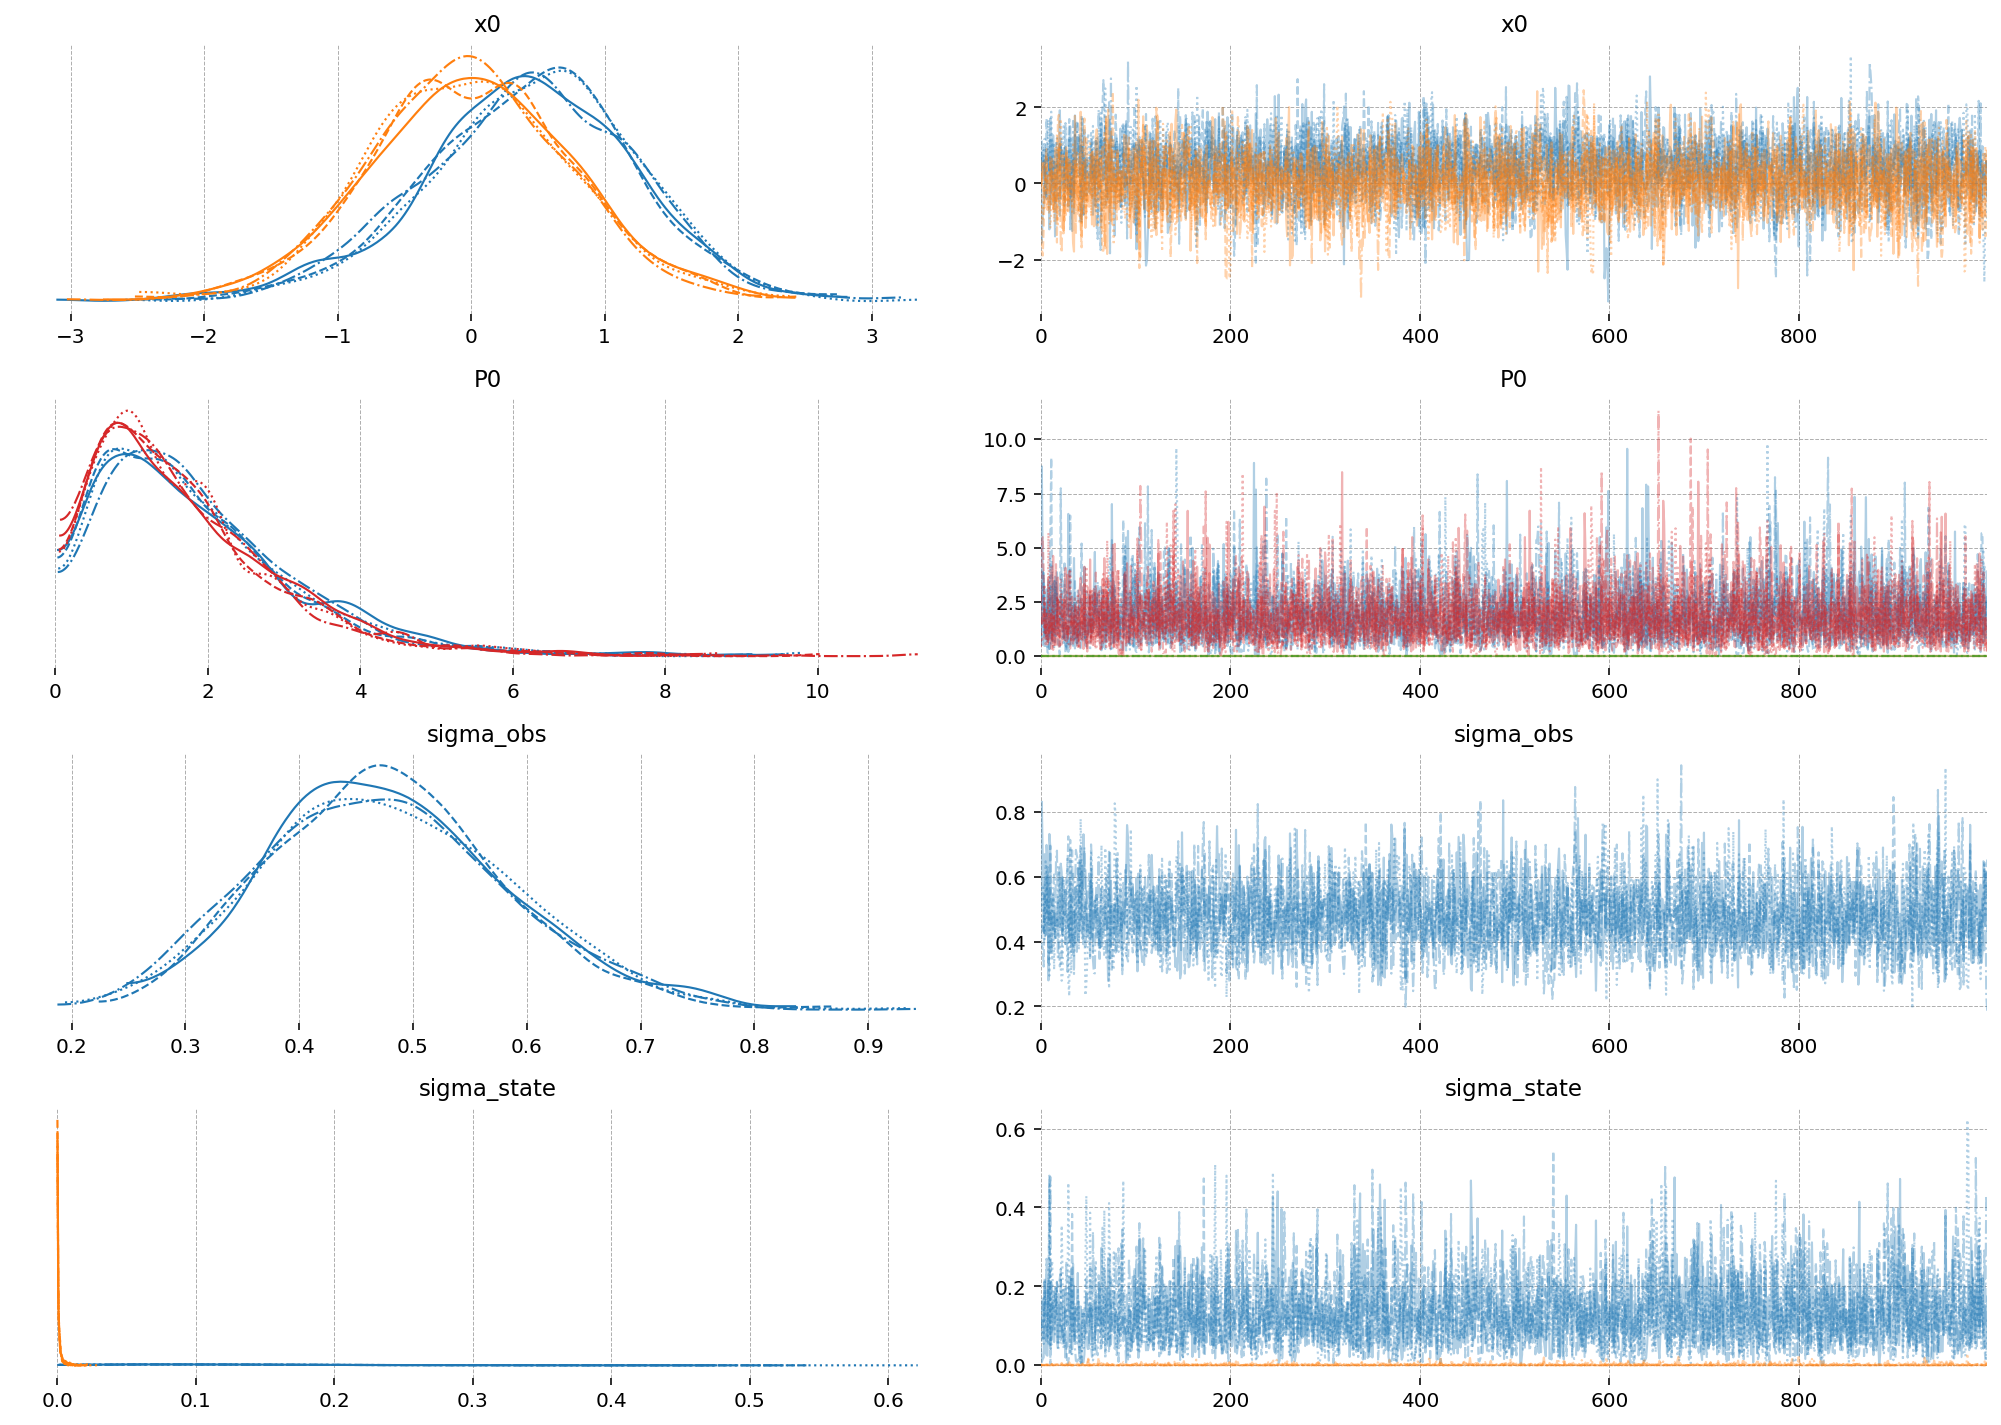

In [17]:
fig, ax = plt.subplots(4, 2, figsize=(14, 10), dpi=144)
az.plot_trace(
    idata,
    var_names=state_space_model.param_names,
    compact=True,
    axes=ax,
)
fig.tight_layout()
plt.show()

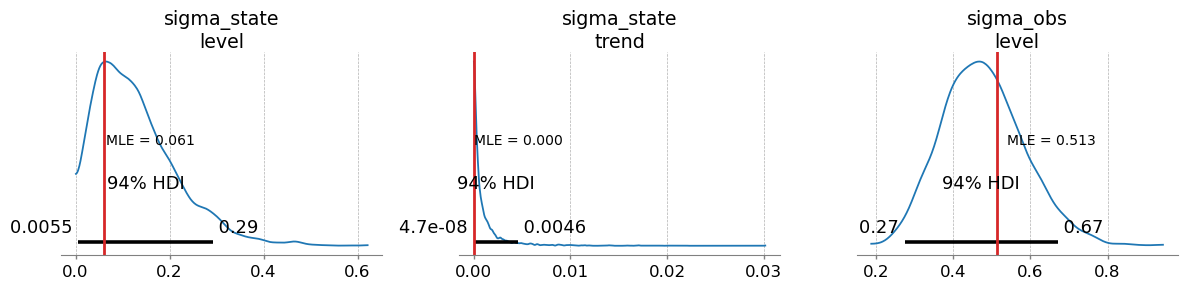

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
az.plot_posterior(
    idata,
    var_names=["sigma_state", "sigma_obs"],
    ax=ax,
    textsize=12,
    point_estimate=None,
)
params = ["sigma2.level", "sigma2.trend", "sigma2.irregular"]

for axis, name in zip(fig.axes, params):
    axis.axvline(res.params[name], color="tab:red", lw=2)
    ymin, ymax = axis.get_ylim()
    midpoint = (ymax - ymin) / 2
    axis.annotate(xy=(res.params[name] * 1.05, midpoint), text=f"MLE = {res.params[name]:0.3f}")

fig.set(facecolor="white")
fig.tight_layout()
plt.show()

#### Conditional Posterior

##### Filtered States

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FE9E449AB20>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [filtered_posterior]


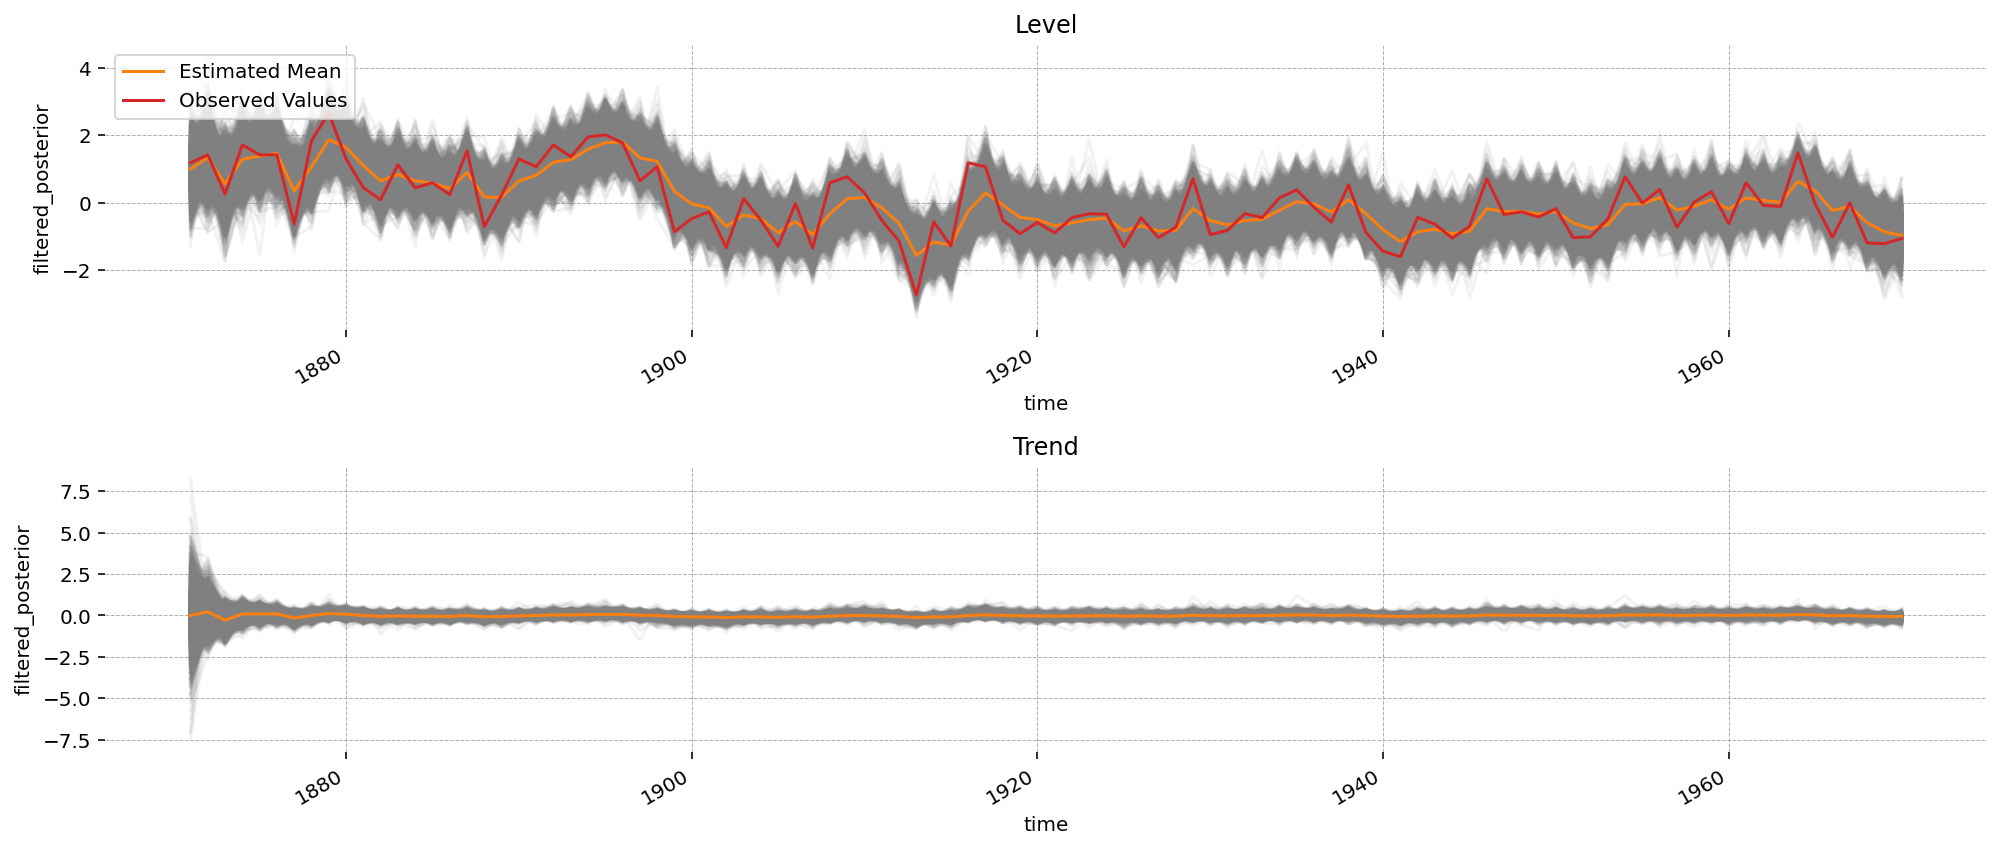

In [19]:
conditional_posterior = state_space_model.sample_conditional_posterior(
    idata, filter_output="filtered"
)
filter_post = az.extract(conditional_posterior, "posterior_predictive").filtered_posterior

fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
for idx, (axis, name) in enumerate(zip(fig.axes, ["level", "trend"])):
    filter_post.sel(states=name).plot.line(
        x="time", ax=axis, color="0.5", alpha=0.1, add_legend=False
    )
    filter_post.sel(states=name).mean(dim="sample").plot.line(
        x="time", ax=axis, color="tab:orange", label="Estimated Mean"
    )
    if idx == 0:
        axis.plot(nile, color="tab:red", label="Observed Values")
    axis.set(title=name.title())

ax[0].legend(loc="upper left")
fig.set_facecolor("w")
fig.tight_layout()
plt.show()

##### Smoothed States

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FE9DFE9A7A0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [smoothed_posterior]


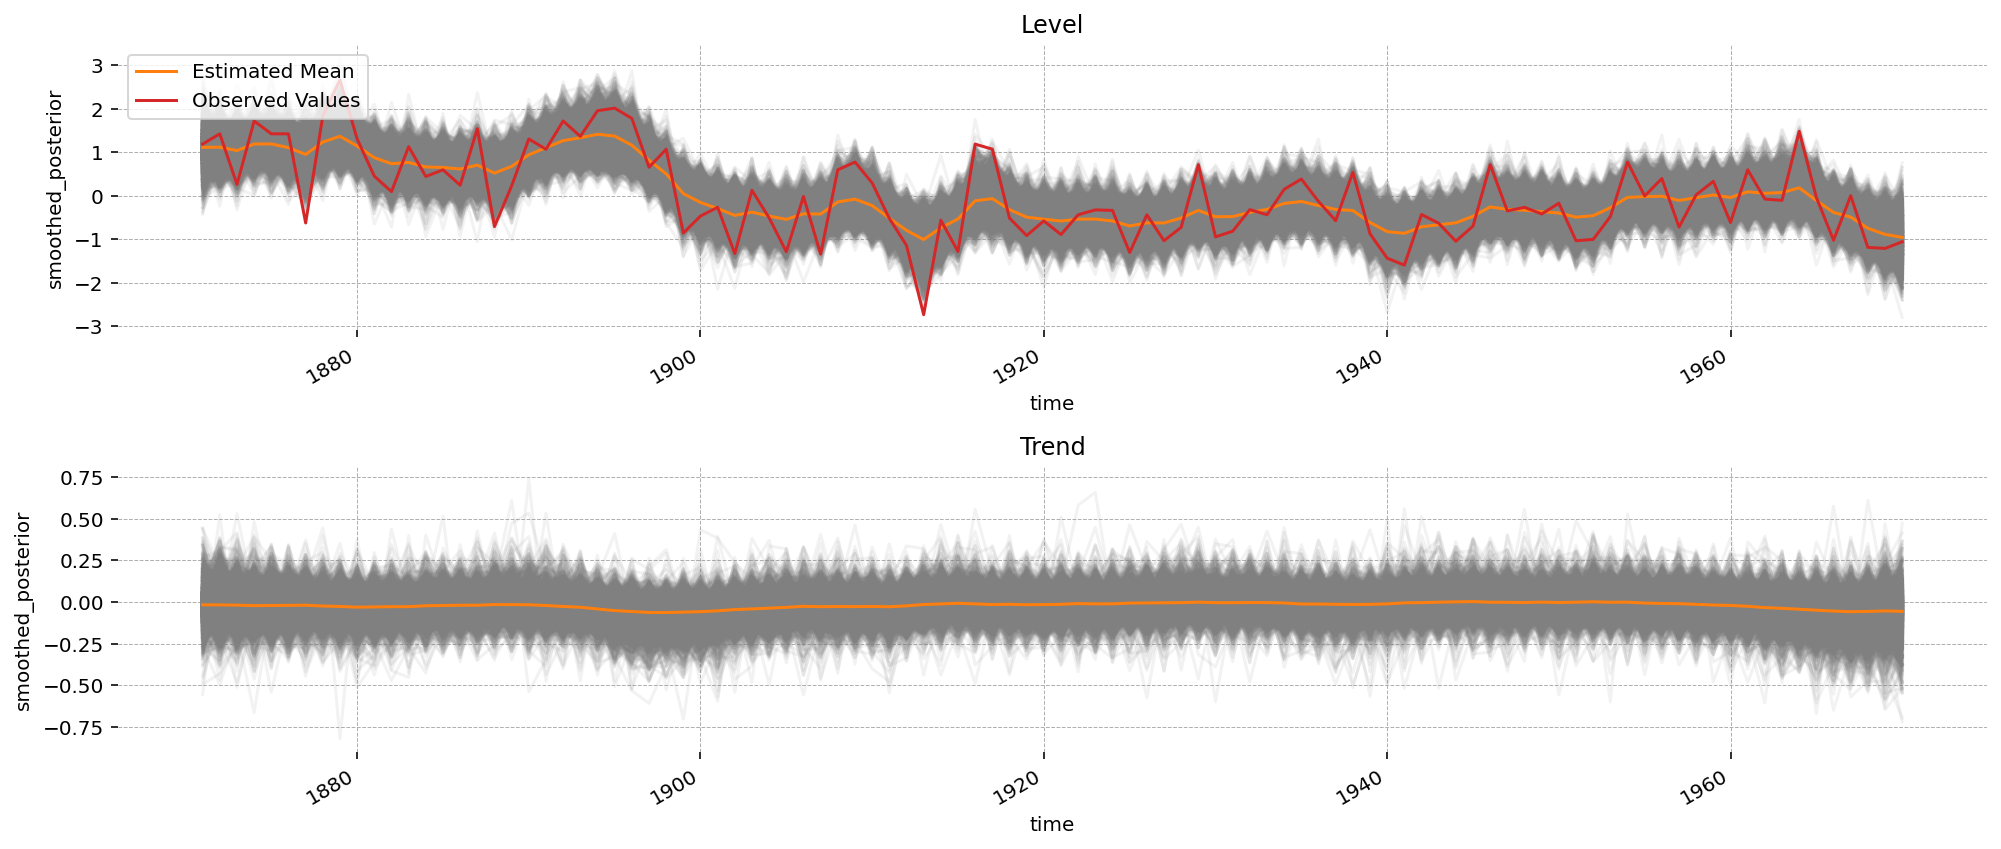

In [20]:
conditional_posterior = state_space_model.sample_conditional_posterior(
    idata, filter_output="smoothed"
)
smooth_post = az.extract(conditional_posterior, "posterior_predictive").smoothed_posterior

fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
for idx, (axis, name) in enumerate(zip(fig.axes, ["level", "trend"])):
    smooth_post.sel(states=name).plot.line(
        x="time", ax=axis, color="0.5", alpha=0.1, add_legend=False
    )
    smooth_post.sel(states=name).mean(dim="sample").plot.line(
        x="time", ax=axis, color="tab:orange", label="Estimated Mean"
    )
    if idx == 0:
        axis.plot(nile, color="tab:red", label="Observed Values")
    axis.set(title=name.title())

ax[0].legend(loc="upper left")
fig.set_facecolor("w")
fig.tight_layout()
plt.show()

#### Unconditional Posterior

Unconditional dynamics are still not much to look at, but the "fanning" in the level has reduced a lot. If we put a dogmatic prior that the initial trend state is always zero the might look nicer, or if there were some covariance between the initial trend and level states.

I mean the bottom line is that this isn't exactly a sophisticated model; it is what it is.

In [21]:
posterior_state_sims = state_space_model.sample_unconditional_posterior(
    idata, steps=100, use_data_time_dim=False
)

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FEA8B5CA0A0>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FEA8B5C9540>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FEA8B5CA500>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [posterior_combined]


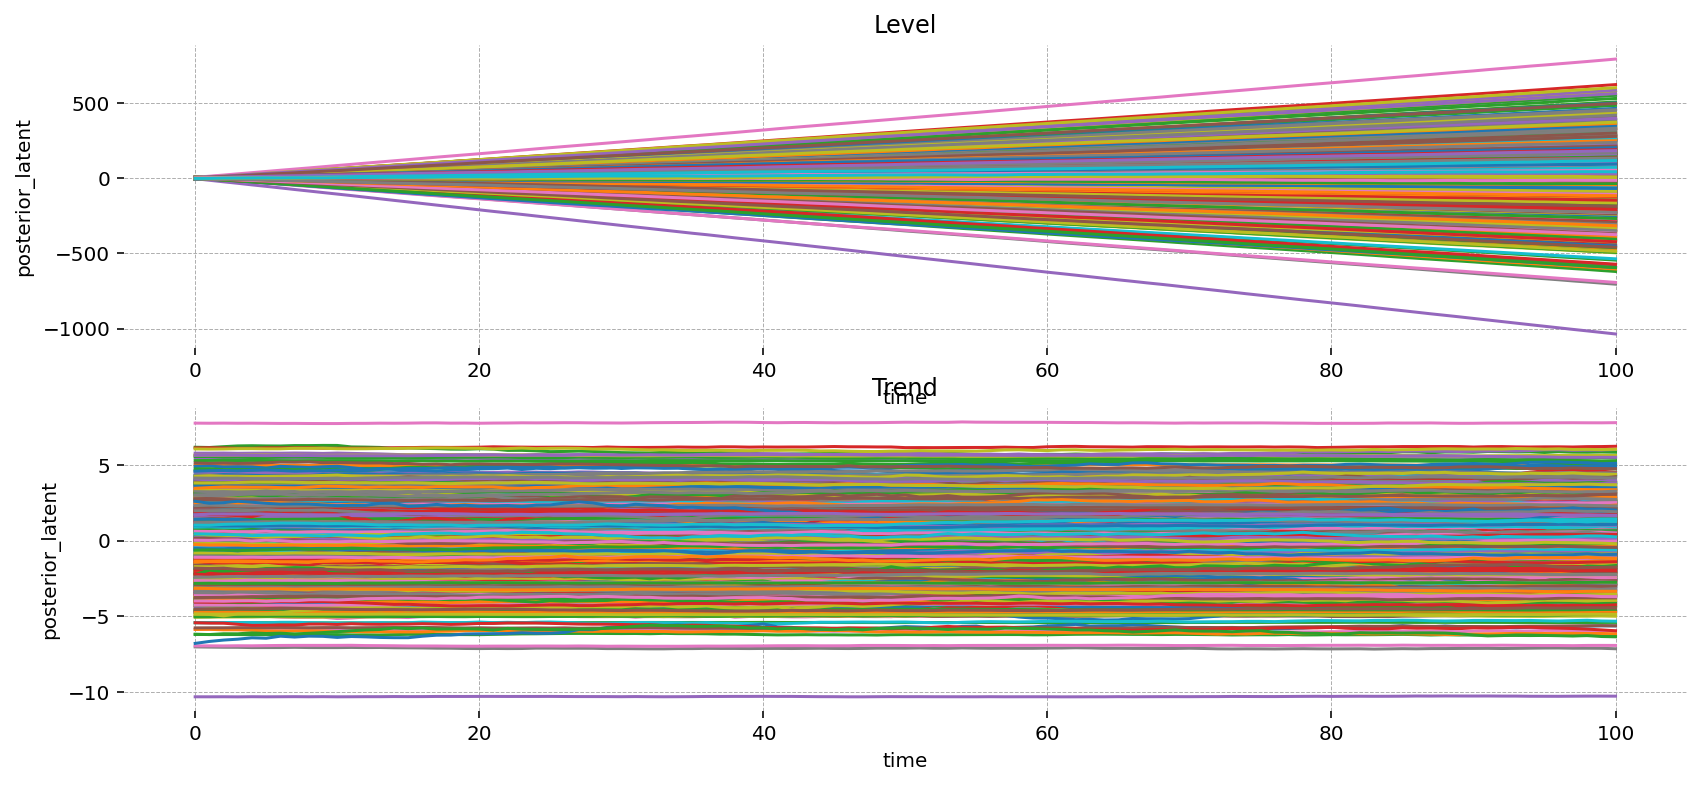

In [22]:
post = az.extract(posterior_state_sims, "posterior_predictive").posterior_latent
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
for idx, (axis, name) in enumerate(zip(fig.axes, ["level", "trend"])):
    post.sel(states=name).plot.line(x="time", ax=axis, add_legend=False)
    axis.set(title=name.title())

## Outputs Compared

In [23]:
az.summary(idata, var_names=["sigma_state", "sigma_obs", "x0", "P0_diag"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_state[level],0.131,0.088,0.005,0.292,0.002,0.001,2672.0,2046.0,1.0
sigma_state[trend],0.001,0.002,0.000,0.005,0.000,0.000,4612.0,2277.0,1.0
sigma_obs[level],0.478,0.107,0.275,0.671,0.002,0.001,3200.0,2859.0,1.0
x0[level],0.434,0.797,-1.130,1.854,0.014,0.011,3582.0,2565.0,1.0
x0[trend],-0.008,0.762,-1.437,1.428,0.012,0.013,4146.0,2558.0,1.0
P0_diag[level],1.876,1.326,0.035,4.170,0.020,0.015,3341.0,1915.0,1.0
P0_diag[trend],1.728,1.265,0.054,3.904,0.019,0.014,3603.0,2056.0,1.0


In [24]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                 height   No. Observations:                  100
Model:             local linear trend   Log Likelihood                -127.011
Date:                Sat, 22 Jul 2023   AIC                            260.022
Time:                        04:02:41   BIC                            267.777
Sample:                    01-01-1871   HQIC                           263.159
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.5125      0.096      5.333      0.000       0.324       0.701
sigma2.level         0.0612      0.042      1.445      0.148      -0.022       0.144
sigma2.trend      1.251e-11      0.000   8.51e-08      1.000      -0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.30   Prob(JB):                         0.98
Heteroskedasticity (H):               0.62   Skew:                             0.05
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Smoother Outputs from all 3 models

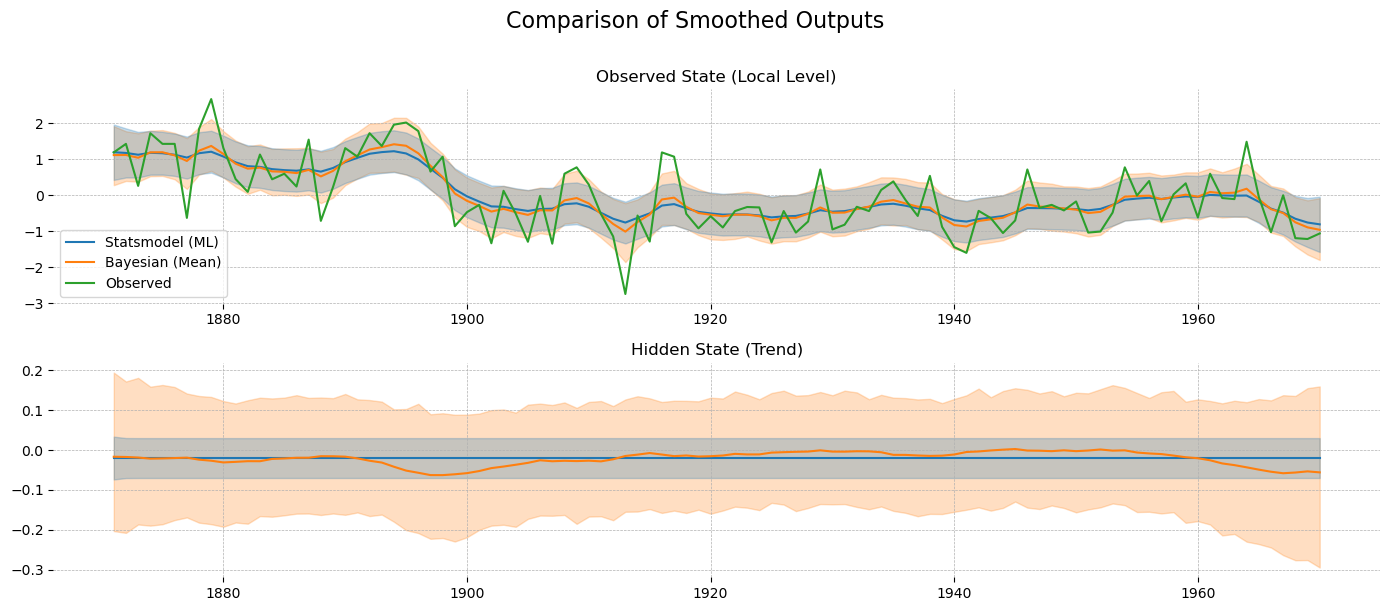

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=100)
x_values = nile.index

mu_pred_long = smooth_post.mean(dim="sample")

ax[0].plot(nile.index, res.states.smoothed.iloc[:, 0], label="Statsmodel (ML)")
ax[0].plot(nile.index, mu_pred_long.sel(states="level").values, label="Bayesian (Mean)")

hdi = az.hdi(conditional_posterior.posterior_predictive).smoothed_posterior

ax[0].fill_between(
    nile.index,
    *hdi.sel(states="level").values.T,
    alpha=0.25,
    color="tab:orange",
)

ax[0].fill_between(
    nile.index,
    res.states.smoothed.iloc[:, 0]
    - 1.96 * np.sqrt(res.states.smoothed_cov.values.reshape(-1, 2, 2)[:, 0, 0]),
    res.states.smoothed.iloc[:, 0]
    + 1.96 * np.sqrt(res.states.smoothed_cov.values.reshape(-1, 2, 2)[:, 0, 0]),
    alpha=0.25,
    color="tab:blue",
)

ax[0].plot(x_values, nile.values, label="Observed")
ax[0].set(title="Observed State (Local Level)")
ax[0].legend()

ax[1].plot(nile.index, res.states.smoothed.iloc[:, 1], label="Statsmodel (ML)")
ax[1].plot(nile.index, mu_pred_long.sel(states="trend").values, label="Bayesian (Mean)")
ax[1].fill_between(
    nile.index,
    *hdi.sel(states="trend").values.T,
    alpha=0.25,
    color="tab:orange",
)

ax[1].fill_between(
    nile.index,
    res.states.smoothed.iloc[:, 1]
    - 1.96 * np.sqrt(res.states.smoothed_cov.values.reshape(-1, 2, 2)[:, 1, 1]),
    res.states.smoothed.iloc[:, 1]
    + 1.96 * np.sqrt(res.states.smoothed_cov.values.reshape(-1, 2, 2)[:, 1, 1]),
    alpha=0.25,
    color="tab:blue",
)


ax[1].set(title="Hidden State (Trend)")
# ax[1].legend()
fig.suptitle("Comparison of Smoothed Outputs", y=1.01, size=16)
fig.set(facecolor="white")
fig.tight_layout()
plt.show()